In [0]:
### Applied Machine Learning Pipeline 95-845 #######
### Analysis of Bitcoin Profitability using exponential smoothening, RNN and LSTM ####
### Submitted by: Malvika Singh, Prakhar Mishra, Simran Handa
### The code proceeds through 
### 1. Data Preprocessing 
### 2. Training the model on RNN, predicting results for RNN  
### 3. Performing the above steps for LSTM.
### 4. Evaluated the models using RMSE 

### We have also performed Exploratory Data Analysis and Exponential Smoothing Model in R 
### Those results are attached in other section

In [89]:
## Importing required libraries for Data Preprocessing and Modeling
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [129]:
## Uploading data from source ####
from google.colab import files
uploaded = files.upload()

Saving data2.csv to data2 (1).csv


In [130]:
### Reading data 
import io
df2 = pd.read_csv(io.BytesIO(uploaded['data2.csv']))
df2.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342169 entries, 0 to 1048574
Data columns (total 16 columns):
Timestamp            342169 non-null int64
Open                 342169 non-null float64
High                 342169 non-null float64
Low                  342169 non-null float64
Close                342169 non-null float64
Volume (BTC)         342169 non-null float64
Volume (Currency)    342169 non-null float64
Weighted Price       342169 non-null float64
date                 342169 non-null object
year                 342169 non-null int64
Competition          342169 non-null int64
Model_Price          342169 non-null float64
year_month           342169 non-null period[M]
Price Ratio          342169 non-null float64
Status               342169 non-null int64
Volatility           342169 non-null float64
dtypes: float64(10), int64(4), object(1), period[M](1)
memory usage: 54.4+ MB


In [5]:
df2.dropna()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
...,...,...,...,...,...,...,...,...
1048570,1388232120,734.60,734.60,730.00,734.55,1.789687,1313.640757,734.005698
1048571,1388232180,734.55,734.55,730.71,730.71,0.110236,80.802051,732.991499
1048572,1388232240,734.40,734.40,730.51,730.51,0.554786,407.247985,734.063488
1048573,1388232300,730.51,733.63,730.51,731.10,0.620446,453.777190,731.372707


In [99]:
df2['date'] = pd.to_datetime(df2['Timestamp'],unit='s').dt.date
df2['year'] = pd.to_datetime(df2['Timestamp'],unit='s').dt.year
df2 = df2.dropna()
df2.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,date,year,Competition,Model_Price,year_month,Price Ratio,Status,Volatility
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411,2011-12-31,2011,4,32.0,2011-12,0.141450,0,0.07
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011,4,32.0,2011-12,0.143125,0,0.00
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012,6,65.0,2012-01,0.070462,0,0.00


In [100]:
df2.loc[df2.index.dropna()]

bitcoin = df2
bitcoin['Competition'] = 0
bitcoin.loc[bitcoin['year'] == 2011, ['Competition']] = 4
bitcoin.loc[bitcoin['year'] == 2012, ['Competition']] = 6
bitcoin.loc[bitcoin['year'] == 2013, ['Competition']] = 66
bitcoin.loc[bitcoin['year'] == 2014, ['Competition']] = 506
bitcoin.loc[bitcoin['year'] == 2015, ['Competition']] = 562
bitcoin.loc[bitcoin['year'] == 2016, ['Competition']] = 644
bitcoin.loc[bitcoin['year'] == 2017, ['Competition']] = 1335
bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,date,year,Competition,Model_Price,year_month,Price Ratio,Status,Volatility
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411,2011-12-31,2011,4,32.0,2011-12,0.141450,0,0.07
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011,4,32.0,2011-12,0.143125,0,0.00
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012,6,65.0,2012-01,0.070462,0,0.00


In [101]:
##bitcoin = df2
bitcoin['Model_Price'] = 0
bitcoin['year_month'] = pd.to_datetime(bitcoin['Timestamp'],unit='s').dt.to_period('M')
bitcoin.loc[bitcoin['year'] == 2011, ['Model_Price']] = 32
bitcoin.loc[bitcoin['year'] == 2012, ['Model_Price']] = 65
bitcoin.loc[bitcoin['year_month'] == "2013-01", ['Model_Price']] = 68
bitcoin.loc[bitcoin['year_month'] == "2013-02", ['Model_Price']] = 68
bitcoin.loc[bitcoin['year_month'] == "2013-03", ['Model_Price']] = 68
bitcoin.loc[bitcoin['year_month'] == "2013-04", ['Model_Price']] = 68
bitcoin.loc[bitcoin['year_month'] == "2013-05", ['Model_Price']] = 68
bitcoin.loc[bitcoin['year_month'] == "2013-06", ['Model_Price']] = 68.73
bitcoin.loc[bitcoin['year_month'] == "2013-07", ['Model_Price']] = 79.83
bitcoin.loc[bitcoin['year_month'] == "2013-08", ['Model_Price']] = 96.36
bitcoin.loc[bitcoin['year_month'] == "2013-09", ['Model_Price']] = 126.01
bitcoin.loc[bitcoin['year_month'] == "2013-10", ['Model_Price']] = 199.575
bitcoin.loc[bitcoin['year_month'] == "2013-11", ['Model_Price']] = 296.25
bitcoin.loc[bitcoin['year_month'] == "2013-12", ['Model_Price']] = 684.72
bitcoin.loc[bitcoin['year_month'] == "2014-01", ['Model_Price']] = 848.03
bitcoin.loc[bitcoin['year_month'] == "2014-02", ['Model_Price']] = 626.196
bitcoin.loc[bitcoin['year_month'] == "2014-03", ['Model_Price']] = 584.2
bitcoin.loc[bitcoin['year_month'] == "2014-04", ['Model_Price']] = 435.926
bitcoin.loc[bitcoin['year_month'] == "2014-05", ['Model_Price']] = 559.79
bitcoin.loc[bitcoin['year_month'] == "2014-06", ['Model_Price']] = 621.0533
bitcoin.loc[bitcoin['year_month'] == "2014-07", ['Model_Price']] = 599.135
bitcoin.loc[bitcoin['year_month'] == "2014-08", ['Model_Price']] = 515.163
bitcoin.loc[bitcoin['year_month'] == "2014-09", ['Model_Price']] = 411.59
bitcoin.loc[bitcoin['year_month'] == "2014-10", ['Model_Price']] = 371.19
bitcoin.loc[bitcoin['year_month'] == "2014-11", ['Model_Price']] = 386.085
bitcoin.loc[bitcoin['year_month'] == "2014-12", ['Model_Price']] = 330.796
bitcoin.loc[bitcoin['year_month'] == "2015-01", ['Model_Price']] = 254.65
bitcoin.loc[bitcoin['year_month'] == "2015-02", ['Model_Price']] = 249.525
bitcoin.loc[bitcoin['year_month'] == "2015-03", ['Model_Price']] = 257.775
bitcoin.loc[bitcoin['year_month'] == "2015-04", ['Model_Price']] = 250.11
bitcoin.loc[bitcoin['year_month'] == "2015-05", ['Model_Price']] = 248.41
bitcoin.loc[bitcoin['year_month'] == "2015-06", ['Model_Price']] = 255.365
bitcoin.loc[bitcoin['year_month'] == "2015-07", ['Model_Price']] = 266.345
bitcoin.loc[bitcoin['year_month'] == "2015-08", ['Model_Price']] = 240.92
bitcoin.loc[bitcoin['year_month'] == "2015-09", ['Model_Price']] = 243.495
bitcoin.loc[bitcoin['year_month'] == "2015-10", ['Model_Price']] = 256.77
bitcoin.loc[bitcoin['year_month'] == "2015-11", ['Model_Price']] = 290.14
bitcoin.loc[bitcoin['year_month'] == "2015-12", ['Model_Price']] = 385.8633
bitcoin.loc[bitcoin['year_month'] == "2016-01", ['Model_Price']] = 412.41
bitcoin.loc[bitcoin['year_month'] == "2016-02", ['Model_Price']] = 396.65
bitcoin.loc[bitcoin['year_month'] == "2016-03", ['Model_Price']] = 417.27
bitcoin.loc[bitcoin['year_month'] == "2016-04", ['Model_Price']] = 440.273
bitcoin.loc[bitcoin['year_month'] == "2016-05", ['Model_Price']] = 443.72
bitcoin.loc[bitcoin['year_month'] == "2016-06", ['Model_Price']] = 674.7
bitcoin.loc[bitcoin['year_month'] == "2016-07", ['Model_Price']] = 687.56
bitcoin.loc[bitcoin['year_month'] == "2016-08", ['Model_Price']] = 687.22
bitcoin.loc[bitcoin['year_month'] == "2016-09", ['Model_Price']] = 752.255
bitcoin.loc[bitcoin['year_month'] == "2016-10", ['Model_Price']] = 824.86
bitcoin.loc[bitcoin['year_month'] == "2016-11", ['Model_Price']] = 863.965
bitcoin.loc[bitcoin['year_month'] == "2016-12", ['Model_Price']] = 982.056
bitcoin.loc[bitcoin['year_month'] == "2017-01", ['Model_Price']] = 1175.525
bitcoin.loc[bitcoin['year_month'] == "2017-02", ['Model_Price']] = 1389.88
bitcoin.loc[bitcoin['year_month'] == "2017-03", ['Model_Price']] = 1542.01
bitcoin.loc[bitcoin['year_month'] == "2017-04", ['Model_Price']] = 1679.52
bitcoin.loc[bitcoin['year_month'] == "2017-05", ['Model_Price']] = 1681.695
bitcoin.loc[bitcoin['year_month'] == "2017-06", ['Model_Price']] = 2239.49
bitcoin.loc[bitcoin['year_month'] == "2017-07", ['Model_Price']] = 2548.427
bitcoin.loc[bitcoin['year_month'] == "2017-08", ['Model_Price']] = 2917.47
bitcoin.loc[bitcoin['year_month'] == "2017-09", ['Model_Price']] = 3263.3
bitcoin.loc[bitcoin['year_month'] == "2017-10", ['Model_Price']] = 4051.67
bitcoin.loc[bitcoin['year_month'] == "2017-11", ['Model_Price']] = 4367.055
bitcoin.loc[bitcoin['year_month'] == "2017-12", ['Model_Price']] = 5579.17
bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,date,year,Competition,Model_Price,year_month,Price Ratio,Status,Volatility
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411,2011-12-31,2011,4,32.0,2011-12,0.141450,0,0.07
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011,4,32.0,2011-12,0.143125,0,0.00
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012,6,65.0,2012-01,0.070462,0,0.00


In [102]:
##Calculating the ratio of the market price and the weighted price
bitcoin['Price Ratio'] =  (bitcoin['Weighted Price'] / bitcoin['Model_Price'] ) 
bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,date,year,Competition,Model_Price,year_month,Price Ratio,Status,Volatility
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411,2011-12-31,2011,4,32.0,2011-12,0.141450,0,0.07
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011,4,32.0,2011-12,0.143125,0,0.00
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012,6,65.0,2012-01,0.070462,0,0.00


In [103]:
##Add a column that puts in the status for the hazard
bitcoin['Status'] = 0
bitcoin.loc[bitcoin['Price Ratio'] >= 1, ['Status']] = 1
bitcoin.loc[bitcoin['Price Ratio'] < 1,['Status']] = 0

##Calculating the volatility
bitcoin['Volatility'] = 0
bitcoin['Volatility'] = bitcoin['High'] - bitcoin['Low']

bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,date,year,Competition,Model_Price,year_month,Price Ratio,Status,Volatility
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411,2011-12-31,2011,4,32.0,2011-12,0.141450,0,0.07
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011,4,32.0,2011-12,0.143125,0,0.00
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012,6,65.0,2012-01,0.070462,0,0.00


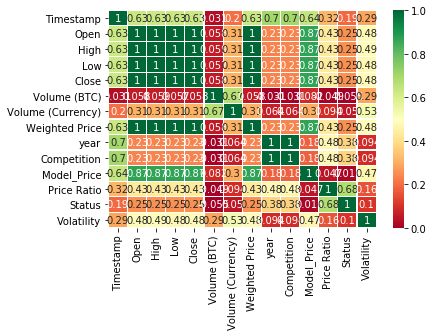

In [104]:
sns.heatmap(bitcoin.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)


In [0]:
######### RNN #########
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
warnings.filterwarnings("ignore")



In [0]:
bit_data = df2
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Price Ratio"].mean()

In [0]:
price_train=data.iloc[:len(data)-50]
price_test=data.iloc[len(price_train):]

In [0]:
#feature scalling (set values between 0-1)
price_train=np.array(price_train)
price_train=price_train.reshape(price_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
price_scaled=scaler.fit_transform(price_train)

In [110]:
timestep=100
x_train=[]
y_train=[]

for i in range(timestep,price_scaled.shape[0]):
    x_train.append(price_scaled[i-timestep:i,0])
    y_train.append(price_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (579, 100, 1)
y_train shape=  (579,)


In [111]:
## Some parts of this code are adapted from https://github.com/kaggle/docker-python and Stackoverflow
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
579/579 [==============================] - 14s 25ms/step - loss: 0.3401
Epoch 2/100
579/579 [==============================] - 11s 20ms/step - loss: 0.0287
Epoch 3/100
579/579 [==============================] - 11s 20ms/step - loss: 0.0165
Epoch 4/100
579/579 [==============================] - 11s 19ms/step - loss: 0.0106
Epoch 5/100
579/579 [==============================] - 11s 20ms/step - loss: 0.0075
Epoch 6/100
579/579 [==============================] - 11s 19ms/step - loss: 0.0060
Epoch 7/100
579/579 [==============================] - 11s 20ms/step - loss: 0.0051
Epoch 8/100
579/579 [==============================] - 12s 20ms/step - loss: 0.0050
Epoch 9/100
579/579 [==============================] - 11s 20ms/step - loss: 0.0046
Epoch 10/100
579/579 [==============================] - 11s 19ms/step - loss: 0.0041
Epoch 11/100
579/579 [==============================] - 11s 19ms/step - loss: 0.0038
Epoch 12/100
579/579 [==============================] - 11s 19ms/step - lo

In [0]:
inputs=data[len(data)-len(price_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [0]:
## Some parts of this code are adapted from https://github.com/kaggle/docker-python and Stackoverflow
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [0]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [0]:
data_test=np.array(price_test)
data_test=data_test.reshape(len(data_test),1)

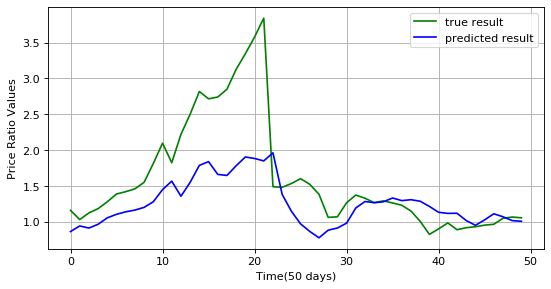

In [119]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="g",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Price Ratio Values")
plt.grid(True)
plt.show()

In [120]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(data_test, predicted_data))
print(rms)

0.6390426669712465


In [121]:
######## Comparison with LSTM neural net  ##########
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
579/579 [==============================] - 4s 7ms/step - loss: 0.0226
Epoch 2/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0057
Epoch 3/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0040
Epoch 4/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0033
Epoch 5/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0030
Epoch 6/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 7/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0031
Epoch 8/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 9/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0027
Epoch 10/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0027
Epoch 11/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 12/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0025
Epoch 13/100


In [0]:
inputs=data[len(data)-len(price_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [0]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [0]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [0]:
data_test=np.array(price_test)
data_test=data_test.reshape(len(data_test),1)

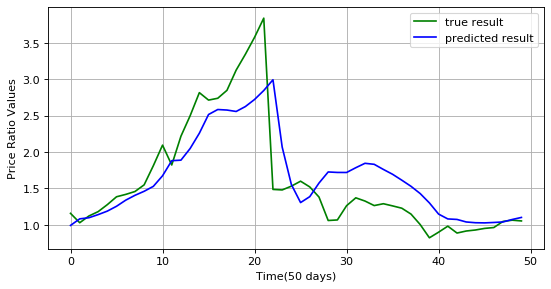

In [126]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="g",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Price Ratio Values")
plt.grid(True)
plt.show()

In [127]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(data_test, predicted_data))
print(rms)

0.43639952494710443
